# Neural Nets / Preceptron

网络预测每日自行车租客人数. Predict share-bike demands.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

## 数据简介

数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列.

下图数据集前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）.

In [3]:
# rides.head()

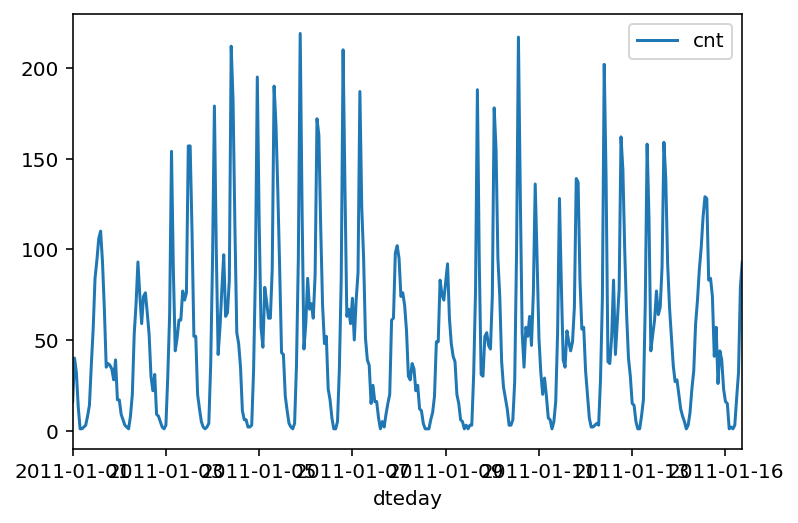

In [4]:
rides[:24*15].plot(x='dteday', y='cnt')

### 虚拟变量

下面分类变量，例如季节、天气、月份。要在模型中包含这些数据，需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop(fields_to_drop, axis=1)
#data.head()

### 调整目标变量

为了更轻松地训练网络，需要对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

保存换算因子，以便当使用网络进行预测时可以还原数据。

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Data split

将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [52]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Network structures

<img src="assets/neural_network.png" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

在神经网络中使用权重将信号从输入层传播到输出层。还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。


In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Set number of nodes in each layers.
        self.input_nodes  = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### self.activation_function to your implemented sigmoid function ####
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # sigmoid
        
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
           
            ### Forward pass ###
            
            # TODO: Hidden layer
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)                           
            hidden_outputs = self.activation_function(hidden_inputs)            

            # TODO: Output layer
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)                    
            final_outputs = final_inputs                                 # No activation on last layer
            

            ### Backward pass ###

            # TODO: Output error
            error = y - final_outputs 
            
            # TODO: Hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            
            # TODO: Backpropagated error terms 
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)  # derivative/backprop of sigmoid

            # Weight step
        
            delta_weights_i_h += hidden_error_term * X.reshape(-1,1)                  # 1-n array transpose
            delta_weights_h_o += output_error_term * hidden_outputs.reshape(-1,1)

        # TODO: Update the weights with GD
        self.weights_hidden_to_output += self.lr*delta_weights_h_o/n_records 
        self.weights_input_to_hidden  += self.lr*delta_weights_i_h/n_records 
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''

        hidden_inputs = np.dot(features, self.weights_input_to_hidden)  # np.multiply is for matrix muitiply
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        final_inputs = np.dot( hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = (final_inputs)
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Test networks

运行这些单元测试，检查你的网络实现是否正确。

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Train

设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。


### Iterations

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### Learning rate

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### hidden nodes

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [50]:
import sys

iterations = 6000
learning_rate = 0.5
hidden_nodes = 20
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}

for ii in range(iterations):
    
    if (ii == 4000):
        network.lr = network.lr/2

    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:10] \
                     + " ... Validation loss: " + str(val_loss)[:10])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.05934297 ... Validation loss: 0.14759765

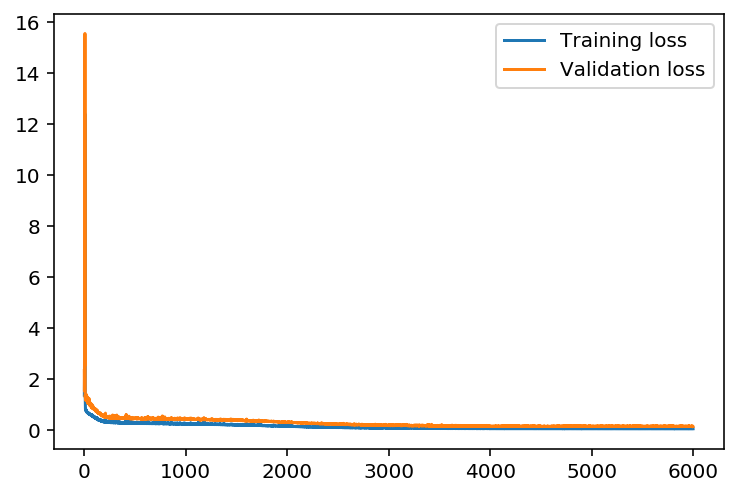

In [51]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Predictions

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

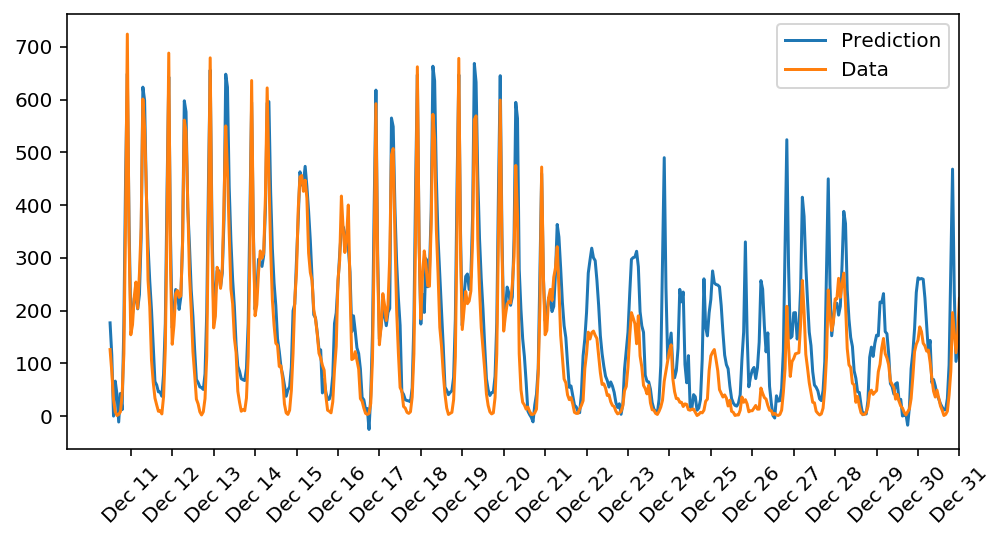

In [44]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？


1. Observation:
    * 1. Convergence:
        * a. If hidden layer node is large such as 100, the nn would be hard to converge into a lower rate;
        * b. If learning rate is set too small (0.005), the training step would take longer time to converge;
        * c. If learning rate is set too large (2), the training step tends to be non-stable;
        * d. Both training and validation loss converged very fast in the first 100 iteration;
        * e. training step tended to be slightly after that, even though it triggered learning rate decay in the middle way.<br>
    <br>
    * 2. Accuracy:
        * a. Model predicted well from Dec 11th to 21th;
        * b. Prediction dropped accuracy after Dec 21th.<br>
<br>
2. Analysis:
    * 1. Normal days is easy to predict, since most of time/data is collected from regular days (data is unbalance);
    * 2. X-mas Holidays (After Dec22) can be considered as non-regular days, so the demands of bikes droped a lot.<br>
<br>
3. Conclusion:
    * 1. NN/preceptrons performance highly depends on the how the data looks like;
    * 2. Data based machine learning algorithm learn experience from data pretty well, but feel a bit hard time to predict in abnormal conditions.<br>
    <br>
4. Future work:
    To made the model more robust or precise:
    * 1. Add more data, such as holiday-like data;
    * 2. Add more hidden layers to enrich model presentation;
    * 3. Apply more machine learning tricks, such as bagging, boosting to improve performance.